## [GITHUB PROJECT REPOSITORY](https://github.com/hoenizhuyn/UQ_2025)|

Overview: Implements the use of the SEIR model (in assignment 1) in combination with **Latin Hypercube Sampling (LHS)** and **Partial Rank Correlation Coefficients (PRCC)** to perform a sensitivity analysis on epidemic dynamics.

**Goals:**
- Simulate the SEIR model using sampled parameters.
- Compute PRCCs to determine the influence of each input parameters (β, α, γ, I₀)  on:
  - Cumulative infections after 60 days (G1)
  - Time to peak infection (G2)
  - where:
    - β = transmission rate
    - α = latency rate (1/incubation period)
    - γ = recovery rate
    - 𝐼0 = initial number of infected individuals


In [1]:
from scipy.stats import qmc
from scipy.stats import rankdata
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

## SEIR Model Definition and Simulation function

Aside from 4 main compartments, this assignment also has s C – Cumulative cases (new addition), that is why we includes dCdt = alpha * E

In [4]:
#  SEIR Model (from Assignment 1, extended with cumulative cases)
def seir_model(t, y, beta, alpha, gamma, N):
    S, E, I, R, C = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    dCdt = alpha * E  # cumulative cases increase when exposed become infectious
    return [dSdt, dEdt, dIdt, dRdt, dCdt]

def simulate_seir(beta, alpha, gamma, I0, T=60, N=80e6):
    if I0 < 0 or I0 > N:
        raise ValueError("I0 must be between 0 and N")

    S0 = N - I0
    E0 = 0
    R0 = 0
    C0 = 0
    y0 = [S0, E0, I0, R0, C0]

    sol = solve_ivp(seir_model, [0, T], y0, args=(beta, alpha, gamma, N),
                    t_eval=np.arange(0, T + 1, 1))
    return sol.t, sol.y


### 1. Latin Hypercube Sampling (LHS)

1. **Divide the CDF (Cumulative Distribution Function) range** — which for a uniform distribution is just \([0, 1]\) — into `n_samples` **equal-probability intervals**:

   \[
   [0, 1/n], [1/n, 2/n], ....., [(n-1)/n, 1]
   \]

2. In **each interval**, randomly choose a point (i.e., draw from the uniform distribution restricted to that interval).

3. This guarantees **one sample per interval**, ensuring **good coverage** of the distribution.

4. In **multidimensional space**, repeat the process **independently per dimension**, and then **shuffle each dimension** to remove artificial correlations.


In [13]:
import numpy as np

def latin_hypercube_uniform(dim, n_samples, low=0, high=1):
    """
    Generate n_samples of dim-dimensional vectors using Latin Hypercube Sampling (LHS)
    from a uniform distribution in the interval [low, high].

    Parameters:
        dim (int): Dimension of the random vectors.
        n_samples (int): Number of samples to generate.
        low (float or array-like): Lower bound(s) of the uniform distribution.
                                   Can be a scalar (applied to all dimensions) or an array of shape (dim,).
        high (float or array-like): Upper bound(s) of the uniform distribution.
                                    Can be a scalar (applied to all dimensions) or an array of shape (dim,).

    Returns:
        samples (np.ndarray): A (n_samples, dim) array of samples from the uniform distribution using LHS.
    """
    # Ensure low and high are numpy arrays with shape (dim,)
    low = np.full(dim, low) if np.isscalar(low) else np.asarray(low)
    high = np.full(dim, high) if np.isscalar(high) else np.asarray(high)

    # Step 1: Divide the [0,1] interval into n_samples strata
    cut_points = np.linspace(0, 1, n_samples + 1)

    # Step 2: Generate random points within each stratum for each dimension
    # Shape: (n_samples, dim)
    u = np.random.rand(n_samples, dim)
    points = np.empty_like(u)

    for j in range(dim):
        # Create intervals for the j-th dimension
        lower = cut_points[:-1]
        upper = cut_points[1:]

        # Random points within each interval
        stratified = lower + (upper - lower) * u[:, j]

        # Shuffle to ensure randomness across samples
        np.random.shuffle(stratified)

        # Assign to the j-th column
        points[:, j] = stratified

    # Step 3: Scale points from [0,1] to [low, high]
    samples = low + points * (high - low)
    return samples


### 2.  Visualize LHS samples

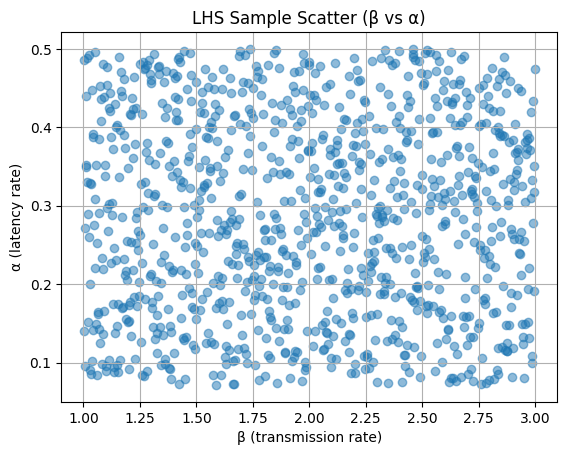

In [6]:
samples_check = latin_hypercube_uniform(4, 1000, low=[1, 1/14, 1/14, 500], high=[3, 1/2, 1/7, 2500])
plt.scatter(samples_check[:, 0], samples_check[:, 1], alpha=0.5)
plt.title("LHS Sample Scatter (β vs α)")
plt.xlabel("β (transmission rate)")
plt.ylabel("α (latency rate)")
plt.grid(True)
plt.show()

- The scatter of points is evenly spread across the rectangle, confirming that the sampling is covering the space well.
- Each dot is a single sample with specific (β, α) values used for simulations in the sensitivity analysis.
=> This plot demonstrates that our LHS implementation works properly for (β, α) pair


### 3. & 4 & 5. PCC and PRCC computation

- PCC (Partial Correlation Coefficient): Computes the linear correlation between each input variable and the output, removing the influence of all other variables. Useful for detecting linear relationships.

- PRCC (Partial Rank Correlation Coefficient): Similar to PCC, but operates on ranked input and output values. It is more robust to nonlinear but monotonic relationships, which are common in epidemiological models.

1. If ranked=True, ranks are assigned to each variable (used for PRCC).
2. For each input parameter, the correlation between it and the output is computed after removing the linear influence of other parameters (via least squares regression).
3. Returns a list of correlation coefficients, one for each input.


`np.linalg.lstsq(A, y)` performs a **least-squares regression**, minimizing the residuals (i.e., the difference between \( Ax \) and \( y \)). Specifically, It solves the following optimization problem

\[
\min |Ax - y\|_2^2
\]

=> finds the best-fitting coefficients `x` (typically a slope and intercept) that minimize the squared difference between the predicted and actual values.
In this case, the matrix \( A \) contains:

- The variable of interest (\( x \))
- A column of ones to include an **intercept** in the model

So the model fitted is: y= ax+b

Where:
- \( a \) is the slope (effect of the input on the output)
- \( b \) is the intercept

#### Source
[NumPy `lstsq` Documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)


In [14]:
def partial_corrcoef(X, y, ranked=False):

    if ranked:  # tells the function to rank data before applying PCC (thus performing PRCC instead of PCC)
        X = np.apply_along_axis(rankdata, 1, X)  # rank each row
        y = rankdata(y)  # rank target

    n, N = X.shape
    corrs = np.zeros(n)

    for i in range(n):
        xi = X[i, :]
        A = np.vstack([xi, np.ones_like(xi)]).T  # (N, 2)
        a, b = np.linalg.lstsq(A, y, rcond=None)[0]  # linear regression

        corr = np.corrcoef(xi, y)[0, 1]
        corrs[i] = corr

    return corrs

## Perform Simulations and Compute PRCCs

###  6. Define parameter bounds

In [9]:
parameter_bounds = {
    "β": (1, 3),            # average contacts per person per week
    "α": (1/14, 1/2),       # latency rate: 2–14 days
    "γ": (1/14, 1/7),       # recovery rate: 7–14 days
    "I0": (500, 2500)       # initial number of infections
}
low = [parameter_bounds[k][0] for k in parameter_bounds]
high = [parameter_bounds[k][1] for k in parameter_bounds]


### 7. Estimate PRCCs for QoIs G1 (C(T)) and G2 (peak time)

In [15]:
# Generate 1000 LHS samples for β, α, γ, I₀
N_samples = 1000
samples = latin_hypercube_uniform(4, N_samples, low=low, high=high)

# Initialize output arrays:
G1 = []  # Total cumulative infections at T=60
G2 = []  # Time of peak infections

# Run SEIR simulation for each sample
for beta, alpha, gamma, I0 in samples:
    t, sol = simulate_seir(beta, alpha, gamma, I0)
    I = sol[2]  # Infectious individuals over time
    C = sol[4]  # Cumulative infections over time
    G1.append(C[-1])  # Final cumulative value
    G2.append(t[np.argmax(I)])  # Time of infection peak

# Convert outputs to NumPy arrays
G1 = np.array(G1)
G2 = np.array(G2)

# Compute Partial Rank Correlation Coefficients (PRCC)
prcc_G1 = partial_corrcoef(samples.T, G1, ranked=True)  # For cumulative infections
prcc_G2 = partial_corrcoef(samples.T, G2, ranked=True)  # For infection peak timing


###  8. Display PRCCs with bar plots and 9. Interpretation

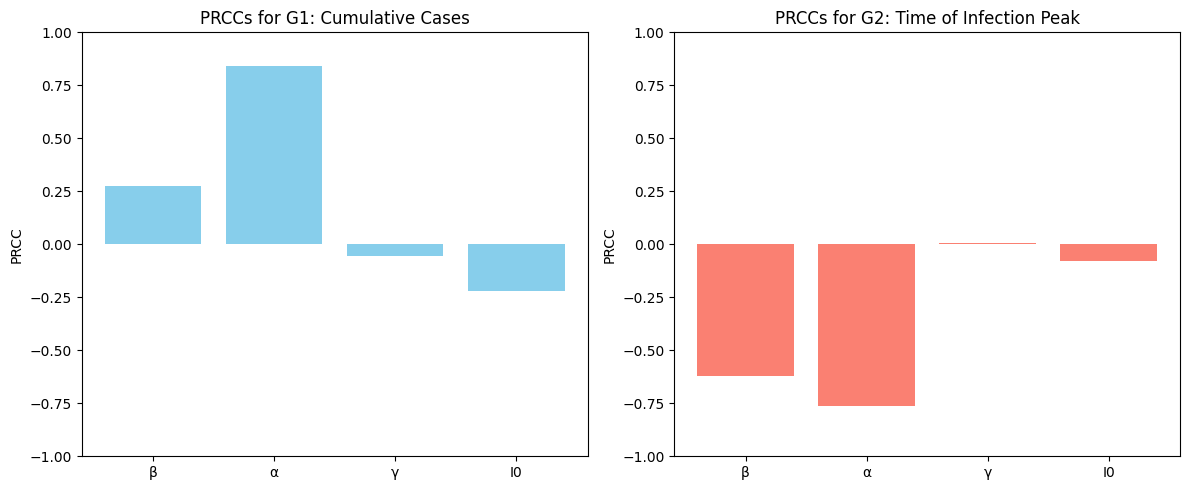

In [11]:
labels = ["β", "α", "γ", "I0"]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(labels, prcc_G1, color='skyblue')
plt.title("PRCCs for G1: Cumulative Cases")
plt.ylabel("PRCC")
plt.ylim(-1, 1)

plt.subplot(1, 2, 2)
plt.bar(labels, prcc_G2, color='salmon')
plt.title("PRCCs for G2: Time of Infection Peak")
plt.ylabel("PRCC")
plt.ylim(-1, 1)

plt.tight_layout()
plt.show()

In [ ]:
print("G1 PRCCs (Cumulative Cases at T=60):")
for name, val in zip(labels, prcc_G1):
    print(f"  {name}: {val:.3f}")

print("\nG2 PRCCs (Time of Infection Peak):")
for name, val in zip(labels, prcc_G2):
    print(f"  {name}: {val:.3f}")



G1 PRCCs (Cumulative Cases at T=60):
  β: 0.273
  α: 0.841
  γ: -0.057
  I0: -0.222

G2 PRCCs (Time of Infection Peak):
  β: -0.621
  α: -0.761
  γ: 0.008
  I0: -0.078


#### G1: Cumulative Infections (Day 60)
- **α (Latency rate)**: Strongest positive effect. Faster incubation increases infections.
- **β (Transmission rate)**: Moderate positive effect   .
- **γ (Recovery rate)** and **I₀ (Initial infections)**: Weak negative effects.

#### G2: Time of Infection Peak
- **α and β**: Strong negative effects (**PRCC ≈ -0.761 and -0.621**). Faster spread → earlier peak.
- **γ**: Negligible impact on timing.
- **I₀**: Slightly negative effect.

#### Key Insight
- **α (Latency rate)** is the most influential parameter on both outcomes.
- **β** also matters, but less so.
- **γ** and **I₀** play minor roles in short-term dynamics.
